In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from sklearn.cross_decomposition import CCA

from statsmodels.multivariate.cancorr import CanCorr

import scipy
from dca.synth_data import (embedded_lorenz_cross_cov_mats, oscillators_dynamics_mat,
                            oscillators_cross_cov_mats, sample_oscillators)
from dca import style, DynamicalComponentsAnalysis
from dca.cov_util import calc_cross_cov_mats_from_data
from dca.data_util import form_lag_matrix

from dca_research import pf_dca

In [2]:
def calc_neg_sqrt(X, min_eigval=1e-5):
    w, V = scipy.linalg.eigh(X)
    if np.min(w) < min_eigval:
        w += (-np.min(w) + min_eigval)
    cov_neg_sqrt = V.dot(np.diag(1. / np.sqrt(w))).dot(V.T)
    return cov_neg_sqrt

def cca_proj(cov_11, cov_12):
    cov_neg_sqrt = calc_neg_sqrt(cov_11)
    to_svd = cov_neg_sqrt.dot(cov_12).dot(cov_neg_sqrt)
    U, s, Vt = scipy.linalg.svd(to_svd)
    V = Vt.T
    U = np.dot(cov_neg_sqrt, U)
    V = np.dot(cov_neg_sqrt, V)
    U /= np.sqrt(np.sum(U**2, axis=0))
    V /= np.sqrt(np.sum(V**2, axis=0))
    return U, V

def cca_proj2(X, Y):
    """
    model = CanCorr(X, Y)
    return model.x_cancoef.T, model.y_cancoef.T
    """
    model = CCA()
    model.fit(X, Y)
    return model.x_weights_, model.y_weights_
    

def pf_dca_proj(cov_11, cov_12, d, n_init):
    opt = pf_dca.PastFutureDynamicalComponentsAnalysis()
    opt.cross_covs = np.array([cov_11, cov_12.T])
    opt.fit_projection(d=d, n_init=n_init)
    U, V = opt.coef_
    return U, V

def sfa_proj(cov_11, cov_12):
    cov_neg_sqrt = calc_neg_sqrt(cov_11)
    cov_sym = cov_12 + cov_12.T
    to_pca = cov_neg_sqrt.dot(cov_sym).dot(cov_neg_sqrt)
    w, V = scipy.linalg.eigh(to_pca)
    w, V = w[::-1], V[:, ::-1]
    #V = V[:, np.argsort(np.abs(w))[::-1]]
    V = np.dot(cov_neg_sqrt, V)
    V /= np.sqrt(np.sum(V**2, axis=0))
    return V

def pca_proj(cov):
    _, V = scipy.linalg.eigh(cov)
    V = V[:, ::-1]
    return V

def dca_proj(cov_11, cov_12, d, n_init=1):
    opt = DynamicalComponentsAnalysis()
    opt.cross_covs = np.array([cov_11, cov_12.T])
    opt.fit_projection(d=d, n_init=n_init)
    V = opt.coef_
    return V

def quad_mat(A, B, C, D):
    top = np.concatenate((A, B), axis=1)
    bottom = np.concatenate((C, D), axis=1)
    mat = np.concatenate((top, bottom), axis=0)
    return mat

def calc_pi(cov_11, cov_12, U, V):
    proj_cov_11 = U.T.dot(cov_11).dot(U)
    proj_cov_22 = V.T.dot(cov_11).dot(V)
    proj_cov_12 = U.T.dot(cov_12).dot(V)
    proj_cov_21 = proj_cov_12.T
    cov_full = quad_mat(proj_cov_11, proj_cov_12, proj_cov_21, proj_cov_22)
    d1 = np.linalg.slogdet(proj_cov_11)[1]
    d2 = np.linalg.slogdet(proj_cov_22)[1]
    d3 = np.linalg.slogdet(cov_full)[1]
    return 0.5 * (d1 + d2 - d3)

def mi_vs_dim(cov_11, cov_12, X, Y, n_init=100):
    N = cov_11.shape[0]
    method_labels = ["CCA", "CCA2", "DCA", "pfDCA", "SFA", "PCA"]
    pi_vals = np.zeros((len(method_labels), N))
    U_cca, V_cca = cca_proj(cov_11, cov_12)
    U_cca2, V_cca2 = cca_proj2(X, Y)
    V_pca = pca_proj(cov_11)
    V_sfa = sfa_proj(cov_11, cov_12)
    for i in range(1, N+1):
        print(i)
        pi_cca = calc_pi(cov_11, cov_12, U_cca[:, :i], V_cca[:, :i])
        pi_cca2 = calc_pi(cov_11, cov_12, U_cca2[:, :i], V_cca2[:, :i])
        V_dca = dca_proj(cov_11, cov_12, i, n_init=n_init)
        Up, Vf = pf_dca_proj(cov_11, cov_12, i, n_init=n_init)
        pi_pf = calc_pi(cov_11, cov_12, Up, Vf)
        pi_dca = calc_pi(cov_11, cov_12, V_dca, V_dca)
        pi_pca = calc_pi(cov_11, cov_12, V_pca[:, :i], V_pca[:, :i])
        pi_sfa = calc_pi(cov_11, cov_12, V_sfa[:, :i], V_sfa[:, :i])
        pi_vals[:, i-1] = [pi_cca, pi_cca2, pi_dca, pi_pf, pi_sfa, pi_pca]
    return pi_vals, method_labels
    

In [46]:
#Analysis 1: get MI vs dim for coupled oscillators and Lorenz attractors

#Get cross-cov mats for all systems
#Lorenz system
#lorenz_cross_cov_mats = embedded_lorenz_cross_cov_mats(N=30, T=20, snr=1.)
#Oscillator system (10 oscillators --> 20-dimensional state)
A = oscillators_dynamics_mat(N=10)
Xo = sample_oscillators(A, 20000)[::10]
XoL = form_lag_matrix(Xo, 2)
XoL -= XoL.mean(axis=0, keepdims=True)
osc_cross_cov_mats = oscillators_cross_cov_mats(A, T=20)
#Run the 'MI vs. dimensionality' analysis for both systems
#pi_lorenz, labels = mi_vs_dim(lorenz_cross_cov_mats[0], lorenz_cross_cov_mats[2].T, n_init=20)
pi_osc, labels = mi_vs_dim(osc_cross_cov_mats[0], osc_cross_cov_mats[10].T,
                           XoL[:, :20], XoL[:, 20:], n_init=1)

#np.savez("cached_fig_data/methods_comp.npz", pi_lorenz=pi_lorenz, pi_osc=pi_osc, labels=labels)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [26]:
#np.savez("methods_comp.npz", pi_lorenz=pi_lorenz, pi_osc=pi_osc, labels=labels)

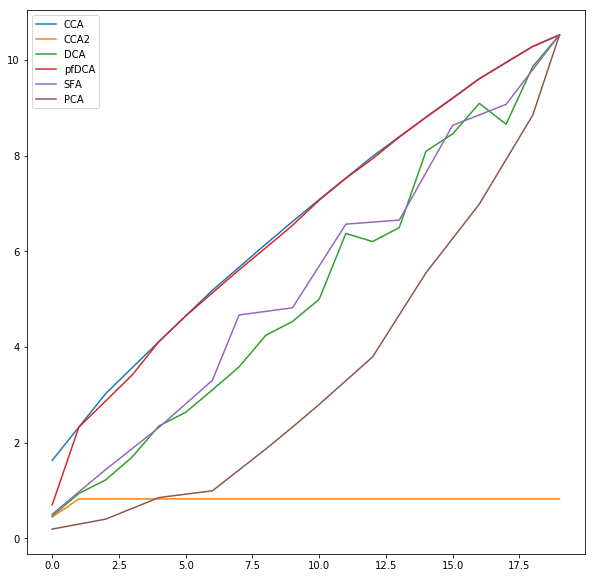

In [48]:
#Plot results!

#d1 = np.load("methods_comp.npz")
#pi_osc=d1["pi_osc"]
#pi_lorenz = d1['pi_lorenz']
#labels=d1["labels"]

fig, ax = plt.subplots(1, figsize=(10, 10))
for pi, label in zip(pi_osc, labels):
    ax.plot(pi, label=label)
ax.legend()
#plot_mi_vs_dim(pi_lorenz, labels, ax, max_dim=5, title="Embedded Lorenz Attractor", xlabel=True)
#plot_dca_autocorr_fns(ax1, ax_inset, autocorr_fn_1, autocorr_fn_2)

#plt.savefig("figures/methods_comp.pdf")


In [33]:
XoL.mean(axis=0)

array([-0.04588465, -0.05087037, -0.0523901 , -0.07358455, -0.06836195,
       -0.06978424, -0.0544801 , -0.04466011, -0.03888999, -0.04877188,
        0.00052053,  0.00324513, -0.00301282,  0.02216823,  0.01161222,
        0.01833487,  0.00279645, -0.00241684, -0.00736934,  0.00619687,
       -0.04575699, -0.05080022, -0.05261687, -0.07372342, -0.0684067 ,
       -0.0697871 , -0.05450442, -0.04476193, -0.0389459 , -0.04862112,
        0.00038964,  0.00319871, -0.00293248,  0.02215927,  0.0115917 ,
        0.01824558,  0.00290427, -0.00246648, -0.00739038,  0.0063787 ])

In [3]:
A = oscillators_dynamics_mat(N=10)
Xo = sample_oscillators(A, 2400000)[::10]
XoL = form_lag_matrix(Xo, 2)
osc_cross_cov_mats = oscillators_cross_cov_mats(A, T=20)

KeyboardInterrupt: 

In [4]:
XoL -= XoL.mean(axis=0, keepdims=True)

In [5]:
osc_cross_cov_mats[[0, 10]].shape

(2, 20, 20)

In [6]:
cov = np.cov(XoL, rowvar=False)

In [7]:
np.allclose(cov[:20, :20], osc_cross_cov_mats[0])

False

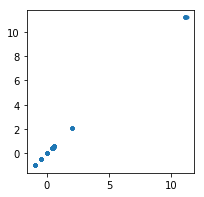

In [10]:
plt.figure(figsize=(3, 3))
plt.scatter(cov[:20, :20].ravel(), osc_cross_cov_mats[0].ravel(), marker='.')

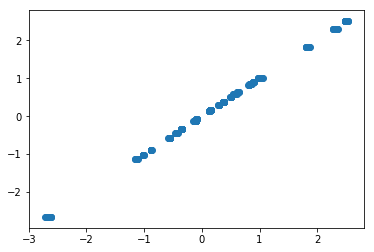

In [12]:
plt.scatter(cov[20:, :20].ravel(), osc_cross_cov_mats[10].ravel())

In [33]:
model0 = CCA(n_components=3)

In [14]:
model1 = CCA(n_components=1)

In [34]:
model0.fit(XoL[:, :20], XoL[:, 20:])
model1.fit(XoL[:, :20], XoL[:, 20:])

CCA(copy=True, max_iter=500, n_components=1, scale=True, tol=1e-06)

In [29]:
A = oscillators_dynamics_mat(N=10)
osc_cross_cov_mats = oscillators_cross_cov_mats(A, T=20)
U, V = cca_proj(osc_cross_cov_mats[0], osc_cross_cov_mats[10].T)

In [58]:
cca_pi = []
#pf_pi = []
dims = np.arange(1, 20)
for d in dims:
    Ud = U[:, :d]
    Vd = V[:, :d]
    pfmodel0 = pf_dca.PastFutureDynamicalComponentsAnalysis(T=1, d=d, n_init=5)
    pfmodel0.cross_covs = np.array([osc_cross_cov_mats[0], osc_cross_cov_mats[10].T])
    pfmodel0.fit_projection()
    pf_pi.append(pfmodel0.score())
    #pf_pi.append(calc_pi(osc_cross_cov_mats[0], osc_cross_cov_mats[1], pfmodel0.coef_[0], pfmodel0.coef_[1]))

    pfmodel1 = pf_dca.PastFutureDynamicalComponentsAnalysis(T=1, d=d)
    pfmodel1.cross_covs = np.array([osc_cross_cov_mats[0], osc_cross_cov_mats[10].T])
    pfmodel1.coef_ = Ud, Vd
    cca_pi.append(pfmodel1.score())
    #cca_pi.append(calc_pi(osc_cross_cov_mats[0], osc_cross_cov_mats[1], Ud, Vd))

ValueError: x and y must have same first dimension, but have shapes (19,) and (38,)

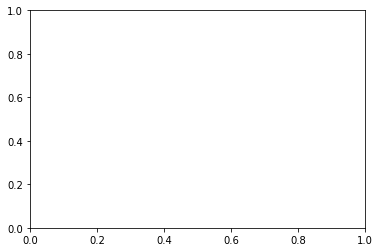

In [59]:
plt.plot(dims, pf_pi)
plt.plot(dims, cca_pi)

In [ ]:
cca_pi

In [ ]:
pf_pi

In [23]:
pfmodel0.coef_

(array([[-0.12239057,  0.05114426, -0.11324334,  0.18020798, -0.10785838,
         -0.40059211,  0.31582836, -0.01996115, -0.03039934],
        [-0.25932925,  0.19267247,  0.15968697, -0.2948788 ,  0.14473148,
         -0.13743918, -0.07123181, -0.30112683,  0.00279596],
        [-0.01293883,  0.10992407, -0.01589268, -0.06294528, -0.15534388,
         -0.03652375, -0.42757111,  0.42867533,  0.04540675],
        [ 0.15024737, -0.05466068, -0.25021046,  0.18534156,  0.40266293,
         -0.33069962,  0.15193108,  0.06683947,  0.0500116 ],
        [ 0.17600582, -0.09956234, -0.17725848, -0.35051441, -0.08467305,
          0.05041802, -0.26434511, -0.47113815, -0.02447976],
        [-0.08427865, -0.14507985,  0.00101255, -0.2940842 ,  0.06772303,
          0.2527658 ,  0.19159024,  0.52727157, -0.01274182],
        [ 0.14346481, -0.2033372 , -0.01378119,  0.46469435,  0.29107248,
          0.22107172, -0.14147624, -0.14020062, -0.11061293],
        [-0.02505092, -0.21726927, -0.19694361, 

In [24]:
pfmodel1.coef_

(array([[ 5.75009869e-03, -9.01887378e-02,  4.30147540e-15,
          1.63152819e-01, -7.06905433e-02,  1.97464772e-02,
          7.04795821e-03,  3.35510041e-01,  6.17283028e-05],
        [ 5.75009869e-03, -7.29642216e-02, -5.30116100e-02,
          1.68137079e-02,  1.77012131e-01,  1.28050036e-02,
         -1.66020769e-02, -2.71397042e-01, -1.97257793e-01],
        [ 5.75009869e-03, -2.78698527e-02, -8.57745868e-02,
         -1.73544262e-01, -3.87089703e-02, -1.18325497e-02,
         -1.73086060e-02,  1.03619597e-01,  3.19108086e-01],
        [ 5.75009869e-03,  2.78698527e-02, -8.57745868e-02,
          9.04425448e-02, -1.53088672e-01, -2.01179215e-02,
          5.90477010e-03,  1.03737012e-01, -3.19069936e-01],
        [ 5.75009869e-03,  7.29642216e-02, -5.30116100e-02,
          1.17647696e-01,  1.33322973e-01, -6.01009555e-04,
          2.09579547e-02, -2.71469608e-01,  1.97157915e-01],
        [ 5.75009869e-03,  9.01887378e-02, -5.30318278e-15,
         -1.63152819e-01,  7.069054

In [62]:
whos

Variable                         Type                                     Data/Info
-----------------------------------------------------------------------------------
A                                ndarray                                  20x20: 400 elems, type `float64`, 3200 bytes
AAA                              ndarray                                  1000: 1000 elems, type `bool`, 1000 bytes
CCA                              ABCMeta                                  <class 'sklearn.cross_decomposition._cca.CCA'>
CanCorr                          type                                     <class 'statsmodels.multi<...>variate.cancorr.CanCorr'>
DynamicalComponentsAnalysis      type                                     <class 'dca.dca.DynamicalComponentsAnalysis'>
U                                ndarray                                  20x20: 400 elems, type `float64`, 3200 bytes
Ud                               ndarray                                  20x19: 380 elems, type `float64`,

In [61]:
AAA = np.ones(1000, dtype=bool)